In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from google.colab import drive
drive.mount('/content/drive')

# 데이터 로드
data = pd.read_csv("/content/drive/MyDrive/MetacodeM/creditcard (1).csv", delimiter=',', dtype=np.float32)

# 피처와 타겟 변수 분리
X = data.drop(columns=['Class'])
y = data['Class']

# 데이터 스케일링
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)


Mounted at /content/drive


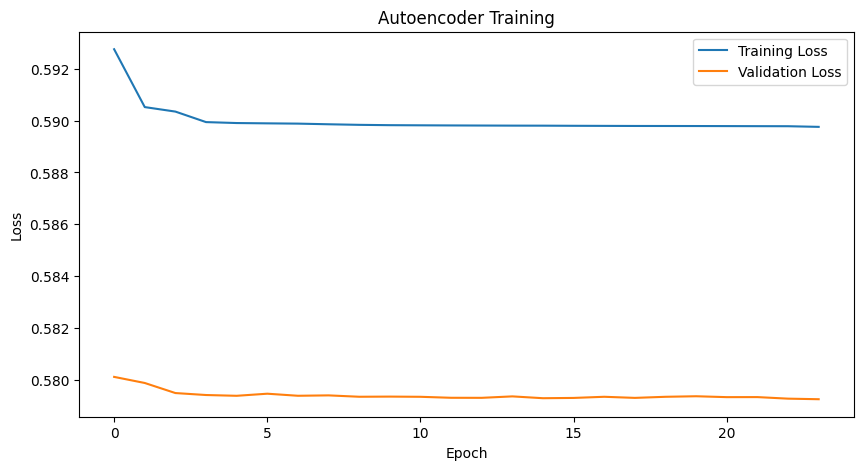

In [2]:
def create_autoencoder(input_dim, encoding_dim):
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(14, activation='relu')(input_layer)
    encoded = Dense(7, activation='relu')(encoded)
    encoded = Dense(encoding_dim, activation='relu')(encoded)
    encoding = encoded
    decoded = Dense(7, activation='relu')(encoded)
    decoded = Dense(14, activation='relu')(decoded)
    decoded = Dense(input_dim, activation='sigmoid')(decoded)

    decoder = Model(encoding, decoded)
    encoder = Model(input_layer, encoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    return autoencoder, encoder

autoencoder, encoder = create_autoencoder(input_dim=X_scaled.shape[1], encoding_dim=5)

history = autoencoder.fit(X_scaled, X_scaled, epochs=24, batch_size=32, validation_split=0.2, verbose=0)

# 학습 과정 시각화
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Autoencoder Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [3]:
encoded_data = encoder.predict(X_scaled)
X_train, X_test, y_train, y_test = train_test_split(encoded_data, y, test_size=0.3, random_state=42)


8901/8901 [==============================] - 15s 2ms/step


In [4]:
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(n_estimators=100, random_state=42),
    'LightGBM': LGBMClassifier(n_estimators=100, random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 356, number of negative: 199008
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 199364, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001786 -> initscore=-6.326170
[LightGBM] [Info] Start training from score -6.326170



Random Forest Results:
Accuracy: 0.9994
Precision: 0.8952
Recall: 0.6912
F1 Score: 0.7801
AUC: 0.9132


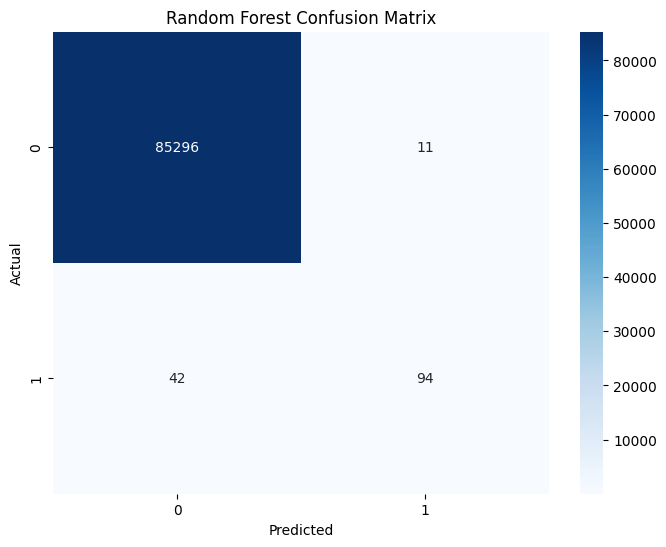

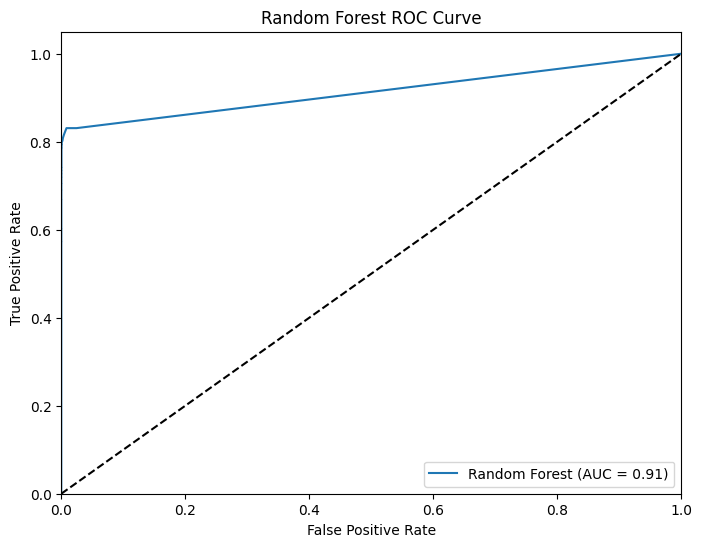

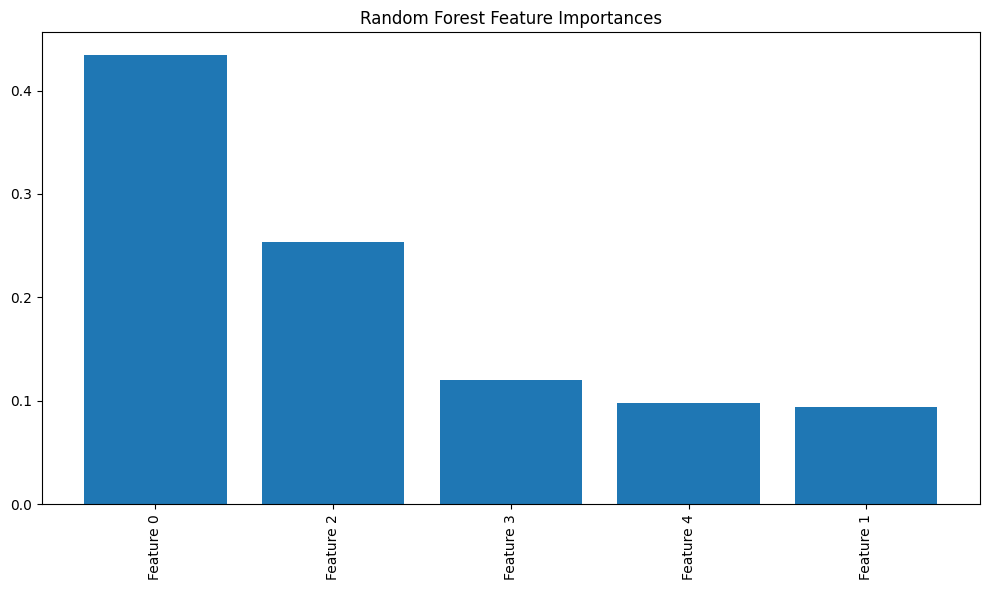


XGBoost Results:
Accuracy: 0.9994
Precision: 0.8818
Recall: 0.7132
F1 Score: 0.7886
AUC: 0.9323


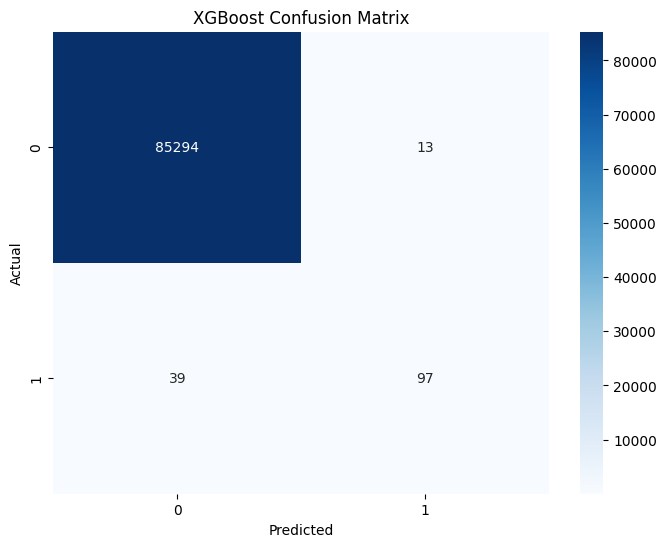

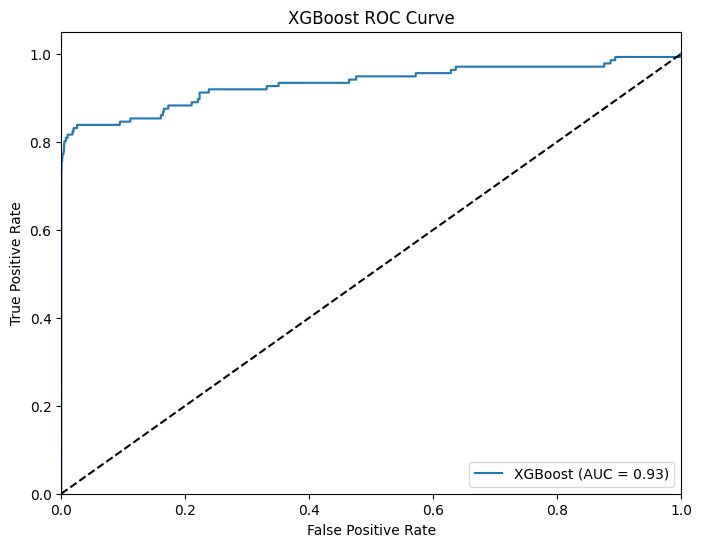

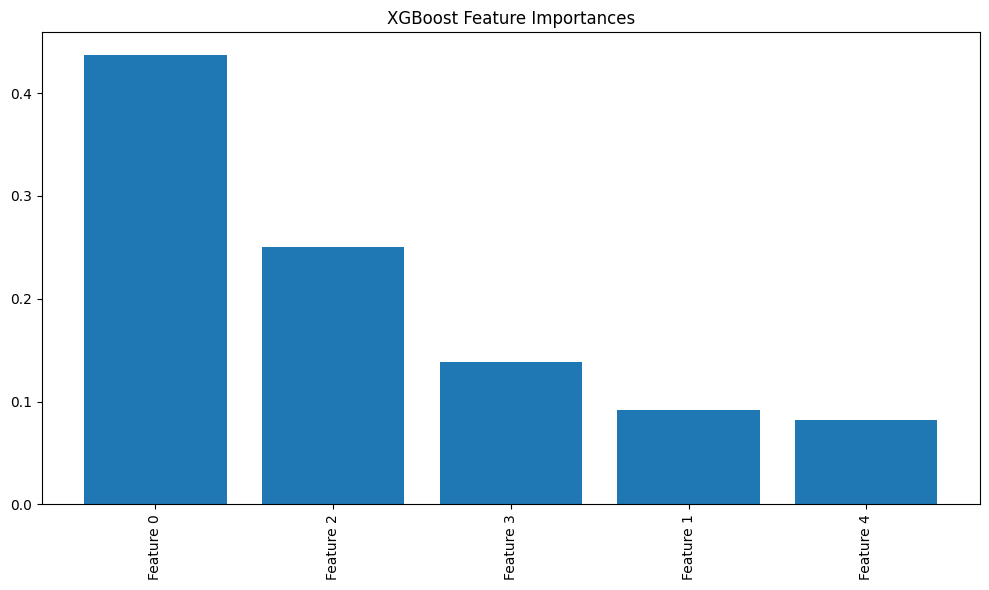


LightGBM Results:
Accuracy: 0.9977
Precision: 0.3628
Recall: 0.5735
F1 Score: 0.4444
AUC: 0.6605


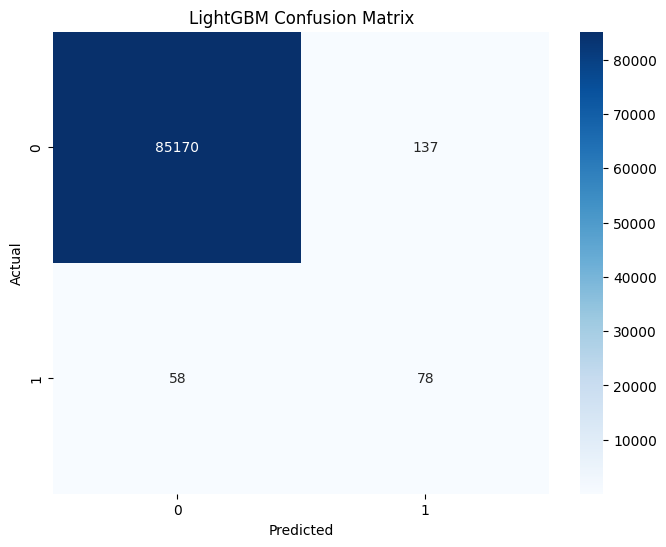

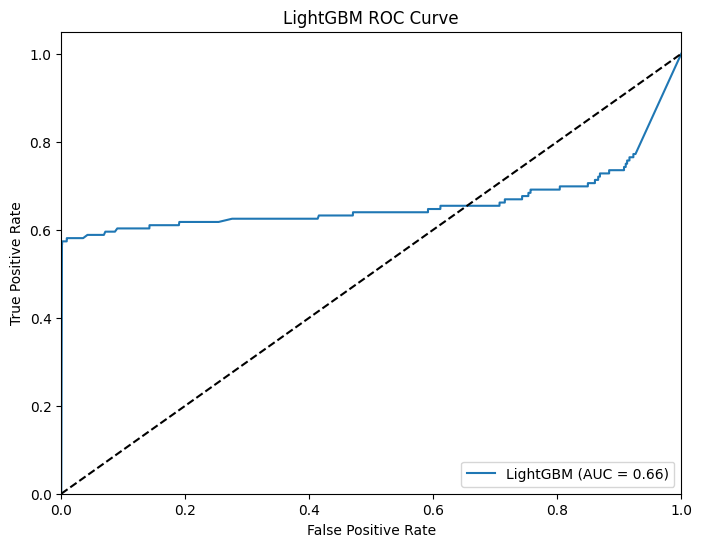

In [5]:
def evaluate_and_visualize(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)

    print(f"\n{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{name} ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

    if name in ['Random Forest', 'XGBoost']:
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        plt.figure(figsize=(10, 6))
        plt.title(f"{name} Feature Importances")
        plt.bar(range(X_test.shape[1]), importances[indices])
        plt.xticks(range(X_test.shape[1]), [f'Feature {i}' for i in indices], rotation=90)
        plt.tight_layout()
        plt.show()

for name, model in models.items():
    evaluate_and_visualize(name, model, X_test, y_test)


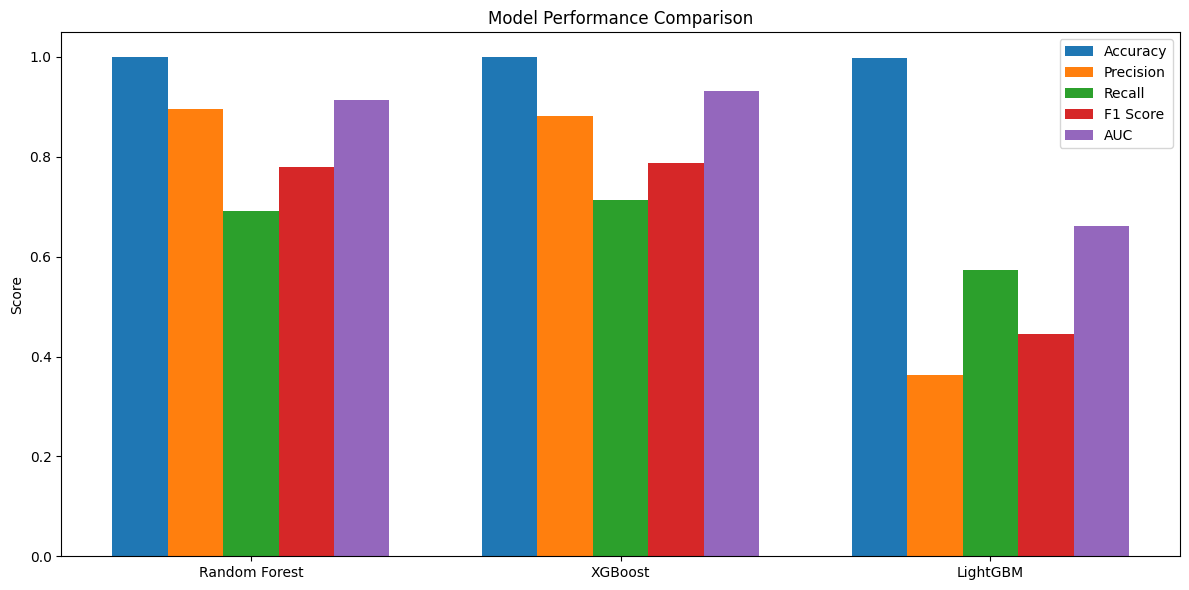

In [6]:
model_names = list(models.keys())
accuracies = [accuracy_score(y_test, model.predict(X_test)) for model in models.values()]
precisions = [precision_score(y_test, model.predict(X_test)) for model in models.values()]
recalls = [recall_score(y_test, model.predict(X_test)) for model in models.values()]
f1_scores = [f1_score(y_test, model.predict(X_test)) for model in models.values()]
aucs = [roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]) for model in models.values()]

plt.figure(figsize=(12, 6))
x = np.arange(len(model_names))
width = 0.15

plt.bar(x - 2*width, accuracies, width, label='Accuracy')
plt.bar(x - width, precisions, width, label='Precision')
plt.bar(x, recalls, width, label='Recall')
plt.bar(x + width, f1_scores, width, label='F1 Score')
plt.bar(x + 2*width, aucs, width, label='AUC')

plt.ylabel('Score')
plt.title('Model Performance Comparison')
plt.xticks(x, model_names)
plt.legend()
plt.tight_layout()
plt.show()
